# Dataset Time Series

## Dataset AMZN.csv

### a. Eksplorasi Data

In [142]:
# Import with pandas
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("AMZN.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5758 entries, 1997-05-15 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5758 non-null   float64
 1   High       5758 non-null   float64
 2   Low        5758 non-null   float64
 3   Close      5758 non-null   float64
 4   Adj Close  5758 non-null   float64
 5   Volume     5758 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 314.9 KB


In [144]:
# How many samples do we have?
len(df)

5758

In [145]:
# Only want closing price for each day
amazon_prices = pd.DataFrame(df["Close"])
amazon_prices.head()

,Close
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083


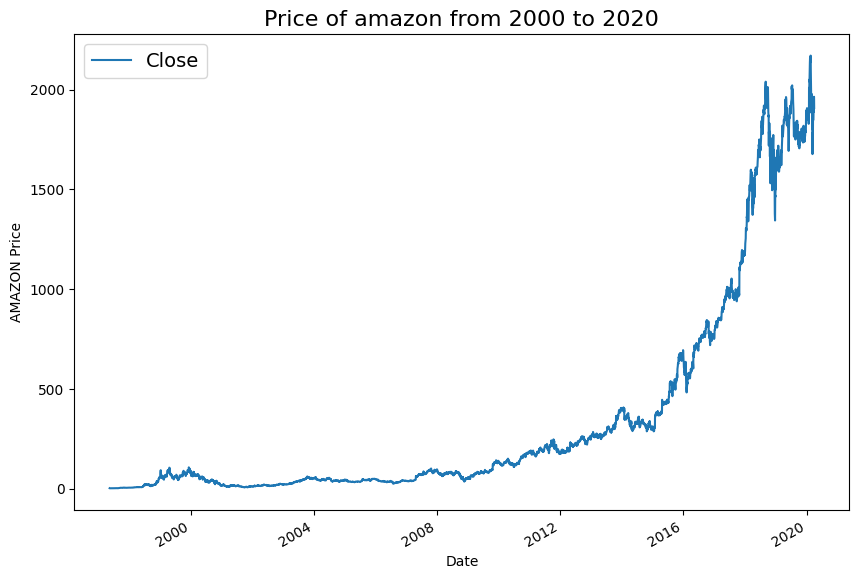

In [146]:
import matplotlib.pyplot as plt
amazon_prices.plot(figsize=(10, 7))
plt.ylabel("AMAZON Price")
plt.title("Price of amazon from 2000 to 2020", fontsize=16)
plt.legend(fontsize=14);

#### Membuat function untuk evaluasi

In [147]:
# Let's get TensorFlow!
import tensorflow as tf

In [148]:
# MASE 
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [149]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()
          }

#### Bagi data menjadi dua bagian input dan output dengan window size = 5 [dari hari senin s.d jumat] dan horizon = 1 [hari senin saja]

In [150]:
# Get amazon date array
timesteps = amazon_prices.index.to_numpy()
prices = amazon_prices["Close"].to_numpy()

timesteps[:10], prices[:10]

(array(['1997-05-15T00:00:00.000000000', '1997-05-16T00:00:00.000000000',
        '1997-05-19T00:00:00.000000000', '1997-05-20T00:00:00.000000000',
        '1997-05-21T00:00:00.000000000', '1997-05-22T00:00:00.000000000',
        '1997-05-23T00:00:00.000000000', '1997-05-27T00:00:00.000000000',
        '1997-05-28T00:00:00.000000000', '1997-05-29T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([1.95833337, 1.72916663, 1.70833337, 1.63541663, 1.42708337,
        1.39583337, 1.5       , 1.58333337, 1.53125   , 1.50520837]))

In [151]:
WINDOW_SIZE = 5 # dari hari senin s.d jumat
HORIZON = 1 # hari senin saja

In [152]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [153]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(6)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5] -> Label: 6


In [154]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=1, horizon=5):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [155]:
import numpy as np

In [156]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(5753, 5753)

In [157]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [1.95833337 1.72916663 1.70833337 1.63541663 1.42708337] -> Label: [1.39583337]
Window: [1.72916663 1.70833337 1.63541663 1.42708337 1.39583337] -> Label: [1.5]
Window: [1.70833337 1.63541663 1.42708337 1.39583337 1.5       ] -> Label: [1.58333337]


In [158]:
# Menentukan ukuran split untuk masing-masing set
train_size = int(0.8 * len(prices))  # 80% untuk training
val_size = int(0.1 * len(prices))   # 10% untuk validation
test_size = len(prices) - train_size - val_size  # Sisa untuk testing

# Membagi data menjadi train, validation, dan test sets
X_train, y_train = timesteps[:train_size], prices[:train_size]
X_val, y_val = timesteps[train_size:train_size+val_size], prices[train_size:train_size+val_size]
X_test, y_test = timesteps[train_size+val_size:], prices[train_size+val_size:]

# Memeriksa panjang masing-masing set
print(f"Train set: {len(X_train)} data points")
print(f"Validation set: {len(X_val)} data points")
print(f"Test set: {len(X_test)} data points")

Train set: 4606 data points
Validation set: 575 data points
Test set: 577 data points


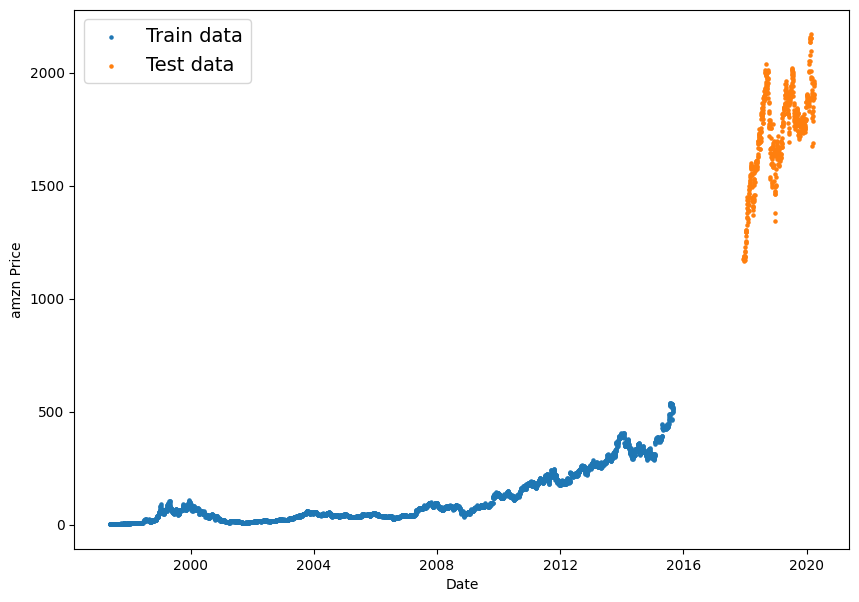

In [159]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("amzn Price")
plt.legend(fontsize=14)
plt.show();

In [160]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  # Menentukan ukuran split untuk masing-masing set
  train_size = int(0.8 * len(prices))  # 80% untuk training
  val_size = int(0.1 * len(prices))   # 10% untuk validation
  test_size = len(prices) - train_size - val_size  # Sisa untuk testing
  
  train_windows = windows[:train_size]
  train_labels = labels[:train_size]
  val_windows = windows[train_size:train_size+val_size]
  val_labels = labels[train_size:train_size+val_size]
  test_windows = windows[train_size+val_size::]
  test_labels = labels[train_size+val_size:]
  return train_windows, val_windows, test_windows, train_labels, val_labels, test_labels

Look at that amazing function, lets test it.

In [161]:
train_windows, val_windows, test_windows, train_labels, val_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(val_windows), len(test_windows), len(train_labels), len(val_labels), len(test_labels)

(4606, 575, 572, 4606, 575, 572)

In [162]:
train_windows.shape, train_labels.shape

((4606, 5), (4606, 1))

In [163]:
train_windows[:5], train_labels[:5]

(array([[1.95833337, 1.72916663, 1.70833337, 1.63541663, 1.42708337],
        [1.72916663, 1.70833337, 1.63541663, 1.42708337, 1.39583337],
        [1.70833337, 1.63541663, 1.42708337, 1.39583337, 1.5       ],
        [1.63541663, 1.42708337, 1.39583337, 1.5       , 1.58333337],
        [1.42708337, 1.39583337, 1.5       , 1.58333337, 1.53125   ]]),
 array([[1.39583337],
        [1.5       ],
        [1.58333337],
        [1.53125   ],
        [1.50520837]]))

In [164]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

#### Membuat modelling checkpoint

In [165]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

#### Membuat function untuk melakukan prediksi

In [166]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

### Modelling: RNN (LSTM)

In [167]:
from tensorflow.keras import layers, regularizers
tf.random.set_seed(42)
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(50, activation="relu")(x) 

# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_1 = tf.keras.Model(inputs=inputs, outputs=output, name="model_1_lstm")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_1.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1_lstm\assets
INFO:tensorflow:Assets written to: model_experiment

In [168]:
# Load in best version of model 1 and evaluate on the test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_lstm/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 2ms/step - loss: 26.4147


26.41474151611328

In [169]:
# Make predictions with our LSTM model
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1182.2847, 1178.9097, 1173.3964, 1176.6688, 1179.4697, 1186.5763,
       1176.1038, 1194.8727, 1194.0518, 1219.4451], dtype=float32)>

In [170]:
# Evaluate model 1 preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 26.414745,
 'mse': 1313.9261,
 'rmse': 36.24812,
 'mape': 1.5452708,
 'mase': 1.0923438}

### Modifikasi arsitektur

In [171]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(50, activation="relu")(x) 

# Add another optional dense layer (you could add more of these to see if they improve model performance)
x = layers.Dense(32, activation="relu")(x)

output = layers.Dense(HORIZON)(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=output, name="model_2_lstm")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_lstm\assets


Model_2_LSTM menambahkan lapisan Dense setelah lapisan LSTM untuk menangkap pola non-linear tambahan yang mungkin ada dalam data.

In [172]:
# Load in best version of model 2 and evaluate on the test data
model_2 = tf.keras.models.load_model("model_experiments/model_2_lstm/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 5ms/step - loss: 29.9127


29.91272735595703

In [173]:
# Make predictions with our LSTM model
model_2_preds = make_preds(model_2, test_windows)
model_2_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1185.846 , 1186.8976, 1184.7811, 1181.2191, 1182.6981, 1182.6542,
       1181.974 , 1184.8237, 1195.9744, 1197.0724], dtype=float32)>

In [174]:
# Evaluate model 2 preds
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 29.912731,
 'mse': 1700.6941,
 'rmse': 41.23947,
 'mape': 1.743804,
 'mase': 1.236998}

In [175]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(70, activation="relu")(x) 

# Add another Dense layer with 32 units and ReLU activation
x = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)

output = layers.Dense(HORIZON)(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=output, name="model_3_lstm")

# Compile model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name),
                       tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

INFO:tensorflow:Assets written to: model_experiments\model_3_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_lstm\assets


Model_3_LSTM meningkatkan jumlah unit LSTM untuk meningkatkan kapasitas model, menambahkan regularisasi L2 pada lapisan Dense untuk mencegah overfitting, dan menggunakan callback EarlyStopping untuk menghindari overfitting selama pelatihan.

In [176]:
# Load in best version of model 3 and evaluate on the test data
model_3 = tf.keras.models.load_model("model_experiments/model_3_lstm/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 30.1143


30.114288330078125

In [177]:
# Make predictions with our LSTM model
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1182.5002, 1186.8169, 1158.9583, 1175.7773, 1188.383 , 1190.2898,
       1174.6376, 1195.9761, 1203.1985, 1207.792 ], dtype=float32)>

In [178]:
# Evaluate model 3 preds
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 30.100832,
 'mse': 1618.3463,
 'rmse': 40.228676,
 'mape': 1.7567952,
 'mase': 1.2447766}

### Compare Models

In [179]:
model_results = pd.DataFrame({"model_1_LSTM": model_1_results,
                              "model_2_LSTM": model_2_results,
                              "model_3_LSTM": model_3_results,
                              }).T
model_results.head(3)

,mae,mse,rmse,mape,mase
model_1_LSTM,26.414745,1313.926147,36.248119,1.545271,1.092344
model_2_LSTM,29.912731,1700.694092,41.239471,1.743804,1.236998
model_3_LSTM,30.100832,1618.346313,40.228676,1.756795,1.244777


Didapat bahwa Model_1 memiliki performa paling baik dengan nilai MAE, RMSE, dan MAPE yang paling kecil dibanding ketiga model. Model 1 memiliki nilai MAE sebesar 26.4 yang merupakan rata - rata kesalahan dari nilai prediksi dengan nilai aktual, berarti prediksi model meleset sebesar 26.4 dari data aslinya. Model memiliki nilai RMSE yang merupakan akar kuadrat dari MSE sebesar 36.2 dan menggambarkan kesalahan model secara umum. Model memiliki nilai MAPE yang merupakan presentase dari kesalahan nilai prediksi dengan nilai aktual sebesar 1.6%.

## Dataset CSCO.csv

### a. Eksplorasi Data

In [103]:
# Import with pandas
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("CSCO.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-02-16,0.0,0.079861,0.073785,0.077257,0.059806,940636800
1990-02-20,0.0,0.079861,0.074653,0.079861,0.061822,151862400
1990-02-21,0.0,0.078993,0.075521,0.078125,0.060478,70531200
1990-02-22,0.0,0.081597,0.078993,0.078993,0.061150,45216000
1990-02-23,0.0,0.079861,0.078125,0.078559,0.060814,44697600


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7589 entries, 1990-02-16 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       7589 non-null   float64
 1   High       7589 non-null   float64
 2   Low        7589 non-null   float64
 3   Close      7589 non-null   float64
 4   Adj Close  7589 non-null   float64
 5   Volume     7589 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 415.0 KB


In [105]:
# How many samples do we have?
len(df)

7589

In [106]:
# Only want closing price for each day
cisco_prices = pd.DataFrame(df["Close"])
cisco_prices.head()

,Close
Date,
1990-02-16,0.077257
1990-02-20,0.079861
1990-02-21,0.078125
1990-02-22,0.078993
1990-02-23,0.078559


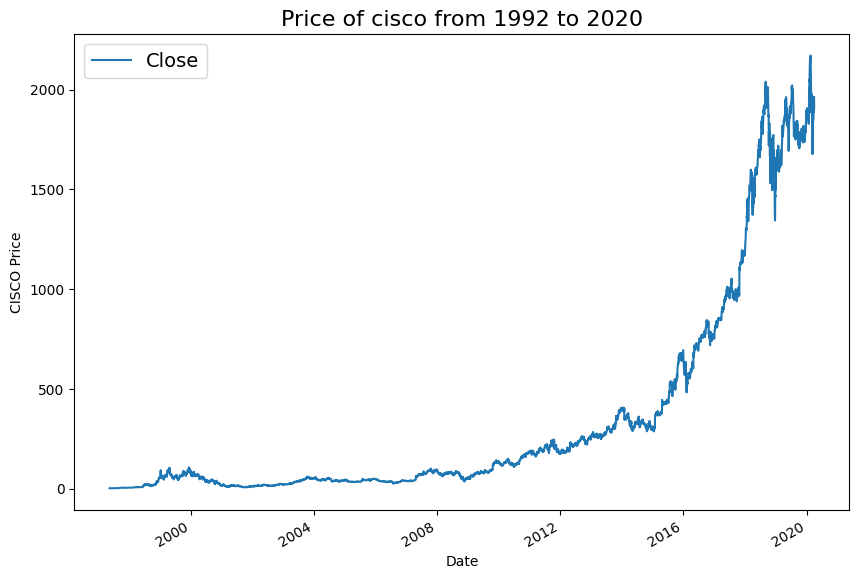

In [107]:
import matplotlib.pyplot as plt
amazon_prices.plot(figsize=(10, 7))
plt.ylabel("CISCO Price")
plt.title("Price of cisco from 1992 to 2020", fontsize=16)
plt.legend(fontsize=14);

#### Bagi data menjadi dua bagian input dan output dengan window size = 5 [dari hari senin s.d jumat] dan horizon = 1 [hari senin saja]

In [108]:
# Get amazon date array
timesteps = cisco_prices.index.to_numpy()
prices = cisco_prices["Close"].to_numpy()

timesteps[:10], prices[:10]

(array(['1990-02-16T00:00:00.000000000', '1990-02-20T00:00:00.000000000',
        '1990-02-21T00:00:00.000000000', '1990-02-22T00:00:00.000000000',
        '1990-02-23T00:00:00.000000000', '1990-02-26T00:00:00.000000000',
        '1990-02-27T00:00:00.000000000', '1990-02-28T00:00:00.000000000',
        '1990-03-01T00:00:00.000000000', '1990-03-02T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([0.07725695, 0.07986111, 0.078125  , 0.07899305, 0.07855903,
        0.07638889, 0.078125  , 0.08072916, 0.07986111, 0.08072916]))

In [109]:
WINDOW_SIZE = 5 # dari hari senin s.d jumat
HORIZON = 1 # hari senin saja

In [110]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=5):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [111]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(6)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5] -> Label: 6


In [112]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(7584, 7584)

In [113]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [0.07725695 0.07986111 0.078125   0.07899305 0.07855903] -> Label: [0.07638889]
Window: [0.07986111 0.078125   0.07899305 0.07855903 0.07638889] -> Label: [0.078125]
Window: [0.078125   0.07899305 0.07855903 0.07638889 0.078125  ] -> Label: [0.08072916]


In [114]:
# Menentukan ukuran split untuk masing-masing set
train_size = int(0.8 * len(prices))  # 80% untuk training
val_size = int(0.1 * len(prices))   # 10% untuk validation
test_size = len(prices) - train_size - val_size  # Sisa untuk testing

# Membagi data menjadi train, validation, dan test sets
X_train, y_train = timesteps[:train_size], prices[:train_size]
X_val, y_val = timesteps[train_size:train_size+val_size], prices[train_size:train_size+val_size]
X_test, y_test = timesteps[train_size+val_size:], prices[train_size+val_size:]

# Memeriksa panjang masing-masing set
print(f"Train set: {len(X_train)} data points")
print(f"Validation set: {len(X_val)} data points")
print(f"Test set: {len(X_test)} data points")

Train set: 6071 data points
Validation set: 758 data points
Test set: 760 data points


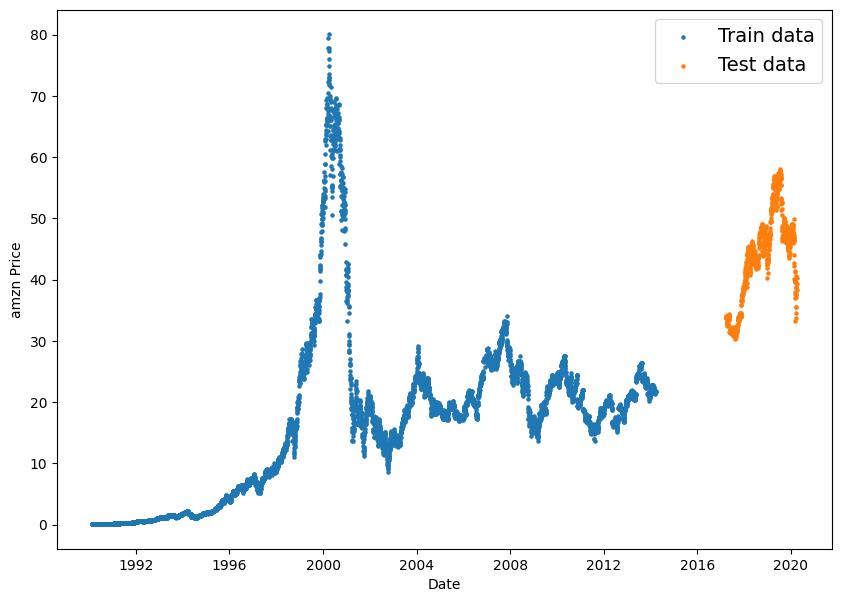

In [115]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("amzn Price")
plt.legend(fontsize=14)
plt.show();

In [116]:
train_windows, val_windows, test_windows, train_labels, val_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(val_windows), len(test_windows), len(train_labels), len(val_labels), len(test_labels)

(6071, 758, 755, 6071, 758, 755)

In [117]:
train_windows.shape, train_labels.shape

((6071, 5), (6071, 1))

In [118]:
train_windows[:5], train_labels[:5]

(array([[0.07725695, 0.07986111, 0.078125  , 0.07899305, 0.07855903],
        [0.07986111, 0.078125  , 0.07899305, 0.07855903, 0.07638889],
        [0.078125  , 0.07899305, 0.07855903, 0.07638889, 0.078125  ],
        [0.07899305, 0.07855903, 0.07638889, 0.078125  , 0.08072916],
        [0.07855903, 0.07638889, 0.078125  , 0.08072916, 0.07986111]]),
 array([[0.07638889],
        [0.078125  ],
        [0.08072916],
        [0.07986111],
        [0.08072916]]))

In [119]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

### Modelling: RNN (LSTM)

In [120]:
from tensorflow.keras import layers, regularizers
tf.random.set_seed(42)
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(50, activation="relu")(x) 

# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_1CSCO = tf.keras.Model(inputs=inputs, outputs=output, name="model_1CSCO_lstm")

# Compile model
model_1CSCO.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_1CSCO.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1CSCO.name)])

INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_1CSCO_lstm\assets

In [121]:
# Load in best version of model 1 and evaluate on the test data
model_1CSCO = tf.keras.models.load_model("model_experiments/model_1CSCO_lstm/")
model_1CSCO.evaluate(test_windows, test_labels)

24/24 [==============================] - 1s 3ms/step - loss: 0.5166


0.5165653824806213

In [122]:
# Make predictions with our LSTM model
model_1CSCO_preds = make_preds(model_1CSCO, test_windows)
model_1CSCO_preds[:10]

24/24 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33.859978, 33.646538, 33.484795, 33.115387, 33.128036, 33.033745,
       33.03655 , 32.988865, 32.698418, 32.50223 ], dtype=float32)>

In [123]:
# Evaluate model 1 preds
model_1CSCO_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1CSCO_preds)
model_1CSCO_results

{'mae': 0.51656544,
 'mse': 0.62374735,
 'rmse': 0.78977674,
 'mape': 1.186375,
 'mase': 1.0077631}

### Modifikasi arsitektur

In [124]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(50, activation="relu")(x) 

# Add another optional dense layer (you could add more of these to see if they improve model performance)
x = layers.Dense(32, activation="relu")(x)

output = layers.Dense(HORIZON)(x)
model_2CSCO = tf.keras.Model(inputs=inputs, outputs=output, name="model_2CSCO_lstm")

# Compile model
model_2CSCO.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_2CSCO.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2CSCO.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_2CSCO_lstm\assets


In [125]:
# Load in best version of model 2 and evaluate on the test data
model_2CSCO= tf.keras.models.load_model("model_experiments/model_2CSCO_lstm/")
model_2CSCO.evaluate(test_windows, test_labels)

24/24 [==============================] - 1s 5ms/step - loss: 0.5161


0.5161158442497253

In [126]:
# Make predictions with our LSTM model
model_2CSCO_preds = make_preds(model_2CSCO, test_windows)
model_2CSCO_preds[:10]

24/24 [==============================] - 1s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33.815865, 33.62234 , 33.46224 , 33.04981 , 33.097595, 32.97559 ,
       33.041664, 32.957428, 32.677063, 32.467087], dtype=float32)>

In [127]:
# Evaluate model 2 preds
model_2CSCO_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2CSCO_preds)
model_2CSCO_results

{'mae': 0.51611584,
 'mse': 0.6154679,
 'rmse': 0.78451765,
 'mape': 1.1833951,
 'mase': 1.006886}

In [128]:
from tensorflow.keras import layers, regularizers
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(70, activation="relu")(x) 

# Add another Dense layer with 32 units and ReLU activation
x = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)

output = layers.Dense(HORIZON)(x)
model_3CSCO = tf.keras.Model(inputs=inputs, outputs=output, name="model_3CSCO_lstm")

# Compile model
model_3CSCO.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_3CSCO.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3CSCO.name),
                       tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

INFO:tensorflow:Assets written to: model_experiments\model_3CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3CSCO_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_3CSCO_lstm\assets


In [129]:
# Load in best version of model 3 and evaluate on the test data
model_3CSCO = tf.keras.models.load_model("model_experiments/model_3CSCO_lstm/")
model_3CSCO.evaluate(test_windows, test_labels)

24/24 [==============================] - 1s 5ms/step - loss: 0.5279


0.5278878211975098

In [130]:
# Make predictions with our LSTM model
model_3CSCO_preds = make_preds(model_3CSCO, test_windows)
model_3CSCO_preds[:10]

24/24 [==============================] - 1s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33.88734 , 33.688637, 33.51574 , 33.129593, 33.1595  , 33.06199 ,
       33.089264, 33.018593, 32.735313, 32.527225], dtype=float32)>

In [131]:
# Evaluate model 3 preds
model_3CSCO_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3CSCO_preds)
model_3CSCO_results

{'mae': 0.5169371,
 'mse': 0.6286358,
 'rmse': 0.7928656,
 'mape': 1.1881562,
 'mase': 1.0084882}

### Compare Models

In [133]:
model_results = pd.DataFrame({"model_1_LSTM": model_1CSCO_results,
                              "model_2_LSTM": model_2CSCO_results,
                              "model_3_LSTM": model_3CSCO_results,
                              }).T
model_results.head(3)

,mae,mse,rmse,mape,mase
model_1_LSTM,0.516565,0.623747,0.789777,1.186375,1.007763
model_2_LSTM,0.516116,0.615468,0.784518,1.183395,1.006886
model_3_LSTM,0.516937,0.628636,0.792866,1.188156,1.008488


Didapat bahwa Model_2 memiliki performa paling baik dengan nilai MAE, RMSE, dan MAPE yang paling kecil dibanding ketiga model. Model 2 memiliki nilai MAE sebesar 0.5 yang merupakan rata - rata kesalahan dari nilai prediksi dengan nilai aktual, berarti prediksi model meleset sebesar 0.5 dari data aslinya. Model memiliki nilai RMSE yang merupakan akar kuadrat dari MSE sebesar 0.78 dan menggambarkan kesalahan model secara umum. Model memiliki nilai MAPE yang merupakan presentase dari kesalahan nilai prediksi dengan nilai aktual sebesar 1.18%.